In [1]:
%reload_ext autoreload
%autoreload 2

In [11]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.utils import reduced_rank_regressor,kernel_reduced_rank_ridge_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from ripple_heterogeneity.readout import predict_downstream_reduced_rank_regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [4]:
basepath = r"Z:\Data\HMC1\day13"

reference_region=["CA1"]
target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]
ripple_expand = 0.2
(
    st,
    cm,
    ripple_epochs,
    ep_epochs,
    ep_df,
    session_epoch,
    nrem_epochs,
    wake_epochs,
) = predict_downstream_reduced_rank_regressor.get_data(basepath, target_regions, reference_region, ripple_expand)

In [7]:

curr_ripples = ripple_epochs[nrem_epochs]

st_par = functions.get_participation(
    st[nrem_epochs].data,
    curr_ripples.starts,
    curr_ripples.stops,
    par_type="firing_rate",
)
# start and end times can be the same for some reason, which
# causes nan as the denominator above is 0
st_par[np.isnan(st_par)] = 0

scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(st_par)

In [21]:
# ca1_sub = "Deep"
# region = "PFC"
# source_cell_type = "Pyr"
# target_cell_type = "Pyr"


def get_test_train_data(
    ca1_sub="Deep", region="PFC", source_cell_type="Pyr", target_cell_type="Pyr"
):
    # get index of ca1 cells
    ca1_idx = (
        cm.brainRegion.str.contains("CA1").values
        & (cm.deepSuperficial == ca1_sub)
        & (cm.putativeCellType.str.contains(source_cell_type))
    )

    # get index of target cells
    if target_cell_type is not None:
        target_idx = (
            cm.brainRegion.str.contains(region).values
            & cm.putativeCellType.str.contains(target_cell_type).values
        )
    else:
        target_idx = cm.brainRegion.str.contains(region).values

    X_train, X_test, y_train, y_test = train_test_split(
        X[ca1_idx, :].T,
        X[target_idx, :].T,
        test_size=0.4,
        random_state=42,
        shuffle=False,
    )
    return X_train, X_test, y_train, y_test

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
# from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error

def get_rank_curve(X_train, X_test, y_train, y_test):
    score = []
    mse = []
    ev = []
    mape = []
    # mle = []
    for i in range(1,15):
        rrr = kernel_reduced_rank_ridge_regression.ReducedRankRegressor()
        rrr.rank = i
        rrr.reg = 1
        rrr.fit(X_train,y_train)
        mse.append(mean_squared_error(y_test,rrr.predict(X_test)))
        score.append(rrr.score(X_test,y_test))
        ev.append(explained_variance_score(y_test,rrr.predict(X_test)))
        mape.append(mean_absolute_percentage_error(y_test,rrr.predict(X_test)))
        # mle.append(mean_squared_log_error(y_test,rrr.predict(X_test)))

    return score, mse, ev, mape



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


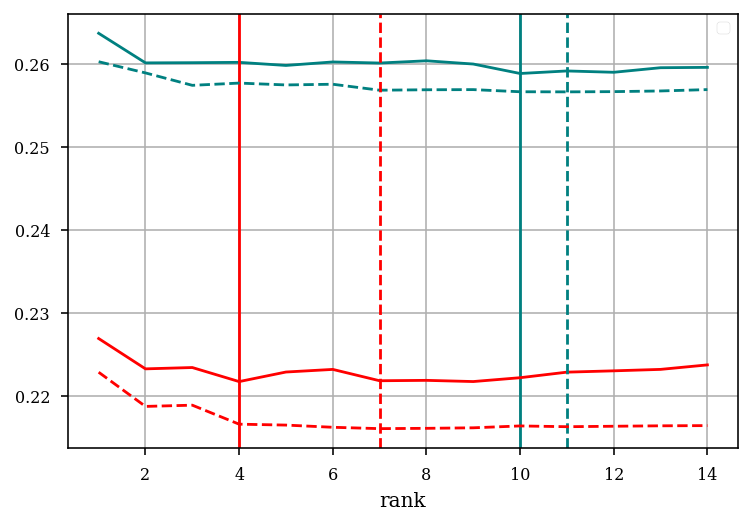

In [40]:
x = range(1, 15)

X_train, X_test, y_train, y_test = get_test_train_data(
    ca1_sub="Deep", region="PFC", source_cell_type="Pyr", target_cell_type="Pyr"
)
score, mse, ev = get_rank_curve(X_train, X_test, y_train, y_test)
plt.plot(x, mse,color="teal")
plt.axvline(np.argmin(mse)+1,color="teal")

X_train, X_test, y_train, y_test = get_test_train_data(
    ca1_sub="Deep", region="MEC", source_cell_type="Pyr", target_cell_type="Pyr"
)
score, mse, ev = get_rank_curve(X_train, X_test, y_train, y_test)
plt.plot(x, mse,color="red")
plt.axvline(np.argmin(mse)+1,color="red")


X_train, X_test, y_train, y_test = get_test_train_data(
    ca1_sub="Superficial", region="PFC", source_cell_type="Pyr", target_cell_type="Pyr"
)
score, mse, ev = get_rank_curve(X_train, X_test, y_train, y_test)
plt.plot(x, mse,color="teal",linestyle="--")
plt.axvline(np.argmin(mse)+1,color="teal",linestyle="--")


X_train, X_test, y_train, y_test = get_test_train_data(
    ca1_sub="Superficial", region="MEC", source_cell_type="Pyr", target_cell_type="Pyr"
)
score, mse, ev = get_rank_curve(X_train, X_test, y_train, y_test)
plt.plot(x, mse,color="red",linestyle="--")
plt.axvline(np.argmin(mse)+1,color="red",linestyle="--")

# plt.axvline(np.log10(16), color="grey", linestyle="--", label=16)
plt.xlabel("rank")
# plt.ylabel("explained variance")
plt.legend()
# plt.ylim(0,.5)
plt.grid()